# Pipeline
Ход решения будет разбит на три главы. В первой главе будет рассмотрена предобработка данных и создание модели машинного обучения по поиску товаров чрезвычайной важности. Вторая глава будет посвящена созданию модели поиска качественных заменителей чрезвычайно важных товаров. Третья глава будет посвящена рабочему скрипту от входных данных до ответа.


# Глава первая.
**Обработка данных.**

Сформулируем определение товара чрезвычайной важности и его заменителей (будет обновление во второй главе из-за увеличения сроков дедлайна):


> Тот товар, что принадлежит определенной иерархической цепочке (например все иерархические уровни = 0 во всех классах), при этом является самым часто покупаемым, а его ближайшего конкурента (в пределах иерархии) покупают менее чем в n раз, то такой товар считается товаром чрезвычайной важности (класс 3). Ближайший к нему товар будет считаться хорошим заменителем (класс 2). Товары не подходящие под определение, считаются не важными и имеют класс 1.

Из определения можно сформировать необходимую структуру данных:
*   Артикул
*   4 иерархических категорий
*   Сколько раз товар был куплен
*   Алкоголь или нет
*   Производитель
*   Цена
*   Категория товара (чрезвычайно необходимый, заменитель, прочее)

Начнем обработку данных, чтобы привести их в необходимый вид:



In [ ]:
import numpy as np
import pandas as pd
np.random.seed(42)

In [ ]:
# Загрузим имеющиеся данные
clients = pd.read_csv('/content/drive/My Drive/Lenta/clients.csv')
materials = pd.read_csv('/content/drive/My Drive/Lenta/materials.csv')
plants = pd.read_csv('/content/drive/My Drive/Lenta/plants.csv')

In [ ]:
# Не смог победить колаб, и загрузить parquet в пандас, так что перезаписал в csv на локальной машине
trans = pd.read_csv('/content/drive/My Drive/Lenta/transactions.csv')

Отфильтруем транзикации - уберем не используемые столбцы, сгруппируем по артикулам, очистим от отрицательных значений, а также уберем акционные товары т.к. по признакам продаваемости они могут оказаться товаром чрезвычайной необходимости, ставшим таковым только из-за скидки.

In [ ]:
# Убираем акционные товары, и строки с отрицательными значениями
trans = trans.loc[trans.is_promo == 0]
trans = trans[trans.sales_sum > 0]
trans = trans[trans.sales_count > 0]

# Удалим не использующиеся столбцы
trans.drop(['chq_id'], axis='columns', inplace=True)
trans.drop(['plant'], axis='columns', inplace=True)
trans.drop(['chq_date'], axis='columns', inplace=True)
trans.drop(['chq_position'], axis='columns', inplace=True)
trans.drop(['client_id'], axis='columns', inplace=True)
trans.drop(['is_promo'], axis='columns', inplace=True)
trans.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [ ]:
# Сгруппируем таблицу по артикулам, сложим полученнные значения кол-ва покупок и суммы
trans = trans.groupby(['material']).sum()
trans['sales_sum'] =  trans['sales_sum'] / trans['sales_count'] # Найдем среднию стоимость товара

In [ ]:
# Посмотрим на данные
trans.head()

,sales_count,sales_sum
material,,
000062284ffb915ba6b88a36e3cb7ba8,49.000,50.648980
00011c1252f877221e0e0a3ddf21858e,77.000,233.915065
000189cbec3b82946747db131d67805a,217.000,56.128940
000273bf6eb4ba9a2ec52c0b5ee564ed,299.769,410.650367
00033dd12618c86f7451b1e18af8bb60,10.000,349.390000


In [ ]:
# Теперь приведем таблицу 'materials' к нужной форме:
materials.drop(['is_private_label'], axis='columns', inplace=True)
materials.loc[:,'category'] = 0 # Столбец показывающий категорию товара (чрезвычайный, заменитель, обычный)

In [ ]:
materials[:1]

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category
0,35cbdf61de9e19c8b417327aaef14c88,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,9eed45f71360b4b1e2590637467220e5,212a38db0ddcd009f1e164cc8483485c,0,0


In [ ]:
# Backup
materials.to_csv('/content/drive/My Drive/Lenta/mat.csv')
trans.to_csv('/content/drive/My Drive/Lenta/trans.csv')

In [ ]:
# В таблице 'materials' объявим индексом - артикул товаров, чтобы можно было
# объединить две таблицы в одну.
materials = materials.set_index(materials['material'])
stack_tables = pd.concat([materials, trans],axis=1,join='inner')
# Проверим что получилось
stack_tables.head()

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
material,,,,,,,,,,
35cbdf61de9e19c8b417327aaef14c88,35cbdf61de9e19c8b417327aaef14c88,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,9eed45f71360b4b1e2590637467220e5,212a38db0ddcd009f1e164cc8483485c,0,0,156.0,118.744936
f0fc5e654a81a7c4b8ba8d7c26546e14,f0fc5e654a81a7c4b8ba8d7c26546e14,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,8a969031832c535daf96e0c2aed8e814,9b0b6c7d55413ad3b67761b7b125b534,0,0,28.0,99.974643
353693e64fb5f9e2d29746d7fe6edf1e,353693e64fb5f9e2d29746d7fe6edf1e,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,b58f7d184743106a8a66028b7a28937c,4c0dc012ebb679a18b244c53c6f59b5a,a3c8be149d718771e892619bd310b961,0,0,36.0,3.479722
5d9e0b4302ce95448cae72165ff4cf5b,5d9e0b4302ce95448cae72165ff4cf5b,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,b58f7d184743106a8a66028b7a28937c,4c0dc012ebb679a18b244c53c6f59b5a,a3c8be149d718771e892619bd310b961,0,0,21.0,3.481905
69374dfb9642c83bd073e1a913af6609,69374dfb9642c83bd073e1a913af6609,NONFOOD,d2ddea18f00665ce8623e36bd4e3c7c5,f52db9f7c0ae7017ee41f63c2a7353bc,ba4078a37e1d6d97a5d3082b255ac3eb,09c62b77ef54b918fb18662f7f25fc78,0,0,25.0,167.461200


In [ ]:
# Backup
stack_tables.to_csv('/content/drive/My Drive/Lenta/backups/stack_tables.csv')

Столбцы представлены в захешированном виде. Сделаем свою нумерацию классов иерархии и производителей.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(stack_tables.hier_level_1)
stack_tables['hier_level_1'] = le.transform(stack_tables.hier_level_1)

le.fit(stack_tables.hier_level_2)
stack_tables['hier_level_2'] = le.transform(stack_tables.hier_level_2)

le.fit(stack_tables.hier_level_3)
stack_tables['hier_level_3'] = le.transform(stack_tables.hier_level_3)

le.fit(stack_tables.hier_level_4)
stack_tables['hier_level_4'] = le.transform(stack_tables.hier_level_4)

le.fit(stack_tables.vendor)
stack_tables['vendor'] = le.transform(stack_tables.vendor)

In [ ]:
# Посмотрим что получилось.
stack_tables.head()

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
material,,,,,,,,,,
35cbdf61de9e19c8b417327aaef14c88,35cbdf61de9e19c8b417327aaef14c88,1,56,250,1197,536,0,0,156.0,118.744936
f0fc5e654a81a7c4b8ba8d7c26546e14,f0fc5e654a81a7c4b8ba8d7c26546e14,1,56,250,1052,2412,0,0,28.0,99.974643
353693e64fb5f9e2d29746d7fe6edf1e,353693e64fb5f9e2d29746d7fe6edf1e,1,56,291,568,2564,0,0,36.0,3.479722
5d9e0b4302ce95448cae72165ff4cf5b,5d9e0b4302ce95448cae72165ff4cf5b,1,56,291,568,2564,0,0,21.0,3.481905
69374dfb9642c83bd073e1a913af6609,69374dfb9642c83bd073e1a913af6609,1,50,380,1438,154,0,0,25.0,167.461200


In [ ]:
#backup
stack_tables.to_csv('/content/drive/My Drive/Lenta/backups/stack_tables_coded.csv')

In [ ]:
# Посмотрим на колличество иерархических классов.
print(len(pd.unique(stack_tables['hier_level_2'])), len(pd.unique(stack_tables['hier_level_3'])), len(pd.unique(stack_tables['hier_level_4'])))

60 391 1966


In [ ]:
# Load
stack_tables = pd.read_csv('/content/drive/My Drive/Lenta/backups/stack_tables_coded.csv')
stack_tables = stack_tables.set_index(stack_tables['material'])

In [ ]:
stack_tables

,material,material.1,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
material,,,,,,,,,,,
35cbdf61de9e19c8b417327aaef14c88,35cbdf61de9e19c8b417327aaef14c88,35cbdf61de9e19c8b417327aaef14c88,1,56,250,1197,536,0,0,156.0,118.744936
f0fc5e654a81a7c4b8ba8d7c26546e14,f0fc5e654a81a7c4b8ba8d7c26546e14,f0fc5e654a81a7c4b8ba8d7c26546e14,1,56,250,1052,2412,0,0,28.0,99.974643
353693e64fb5f9e2d29746d7fe6edf1e,353693e64fb5f9e2d29746d7fe6edf1e,353693e64fb5f9e2d29746d7fe6edf1e,1,56,291,568,2564,0,0,36.0,3.479722
5d9e0b4302ce95448cae72165ff4cf5b,5d9e0b4302ce95448cae72165ff4cf5b,5d9e0b4302ce95448cae72165ff4cf5b,1,56,291,568,2564,0,0,21.0,3.481905
69374dfb9642c83bd073e1a913af6609,69374dfb9642c83bd073e1a913af6609,69374dfb9642c83bd073e1a913af6609,1,50,380,1438,154,0,0,25.0,167.461200
...,...,...,...,...,...,...,...,...,...,...,...
0ddd164eb2c9365fdd0819ff3e69b7d0,0ddd164eb2c9365fdd0819ff3e69b7d0,0ddd164eb2c9365fdd0819ff3e69b7d0,0,37,198,981,3983,0,0,1.0,265.490000
e218c4c3676927e53b95a12ffe9e721a,e218c4c3676927e53b95a12ffe9e721a,e218c4c3676927e53b95a12ffe9e721a,0,0,348,1210,3554,1,0,7.0,469.990000
9a5e2e34d8406616f5981868b4576444,9a5e2e34d8406616f5981868b4576444,9a5e2e34d8406616f5981868b4576444,1,59,218,1755,1312,0,0,30.0,398.385000


Для определения класса товара, необходимо смотреть на эквивалентные товары в данном классе. Сделаем небольшой код который будет находить классы товаров:

In [ ]:
%%time
# 391 - колличество категорий в 3 иерархической ступени.
for i in range(391):
    x = len(stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == 0) & (stack_tables.hier_level_3 == i)])
    if x > 0:
      for z in range(1966):
        c = len(stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == 0) & (stack_tables.hier_level_3 == i) & (stack_tables.hier_level_4 == z)])
        if c > 0:
          print(' 3 иерархический класс товара:', i, '\n', '4 иерархический класс товара:', z)
          break
      if c > 0:
        break

 3 иерархический класс товара: 54 
 4 иерархический класс товара: 440
CPU times: user 1.2 s, sys: 93 ms, total: 1.3 s
Wall time: 1.31 s


Выполнение такого поиска товаров с 2-мя вложеными циклами занимает приличное время, попробуем ускорить процесс.

Для начала отбросим 4ый признак.

In [ ]:
%%time
# 391 - колличество категорий в 3 иерархической ступени.
for i in range(391):
    x = len(stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == 0) & (stack_tables.hier_level_3 == i)])
    if x > 0:
          print(i)
        

54
79
80
205
210
348
CPU times: user 783 ms, sys: 43.4 ms, total: 826 ms
Wall time: 849 ms


Посмотрим на данные:

In [ ]:
stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == 0) & (stack_tables.hier_level_3 == 54)].sort_values('sales_count', ascending=False)[:5]

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
material,,,,,,,,,,
a098532214e2f3f02da3c34d20a6cdeb,a098532214e2f3f02da3c34d20a6cdeb,0,0,54,1822,1282,1,0,428.0,185.750631
33477f5020f66ca9d84392159b380439,33477f5020f66ca9d84392159b380439,0,0,54,1822,3173,1,0,183.0,497.938415
e93141c3deef288dbf73d0df60728302,e93141c3deef288dbf73d0df60728302,0,0,54,659,1653,1,0,180.0,124.852944
abf05c3fa6995ac27f9b4b8f70fe8029,abf05c3fa6995ac27f9b4b8f70fe8029,0,0,54,659,3173,1,0,139.0,339.768993
6b03d09c3189fbaf34628aaeaa5d8cff,6b03d09c3189fbaf34628aaeaa5d8cff,0,0,54,1822,3888,1,0,122.0,149.325246


Первые две строчки занимает товар из одного класса, причем продажи первого выше в более чем в 2 раза от соседа, что говорит о его важности и наделяет маркировкой класса 3.

Также мы видим то следующие строчки занимает товар из другой категории 4го класса, разница с его соседом составляет не существенна, однако стоит смотреть на такие данные алгоритмом.

Попробуем реализовать это:

In [ ]:
# Зададим порог, если товар покупает в threshold раз чаще чем близжайшего конкурента,
# то такой товар чрезвычайно важный.
threshold = 1.6

In [ ]:
%%time
#for food
for second in range(60):
    x = len(stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == second)]) # Проверка условий нахождения в иерархическом классе 2-го уровня.
    if x > 0:

      # Проверка условий нахождения в иерархическом классе 3-го уровня.
      for third in range(391):
        y = len(stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)])
        if y > 0:
          
          # Осортируем полученый список по количеству покупок.
          df = stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)].sort_values('sales_count', ascending=False)[:10]
              
          for fourth in pd.unique(df.hier_level_4):

            # Если в данном иерархическом классе товаров больше 2х, то сравниваем колличество покупок и выделяем чрезвычайно важный и его заменитель.
            if len(df[df.hier_level_4 == fourth]) >= 2:              
              if (df[df.hier_level_4 == fourth].sales_count[0] / df[df.hier_level_4 == fourth].sales_count[1]) > threshold:

                df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)[:2]
      
                stack_tables.at[df2.index[0], 'category'] = 2  # Устанавливаем категорию чрезвычайно важного товара.
                stack_tables.at[df2.index[1], 'category'] = 1  # И его заменителя.

            # Если товар единственный в своем классе и его много берут, тоже считаем его чрезвычайно важным.
            elif len(df[df.hier_level_4 == fourth]) == 1:
               df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)
               if df2['sales_count'].item() > 150:
                stack_tables.at[df2.index[0], 'category'] = 2

CPU times: user 28.8 s, sys: 1.76 s, total: 30.5 s
Wall time: 30.8 s


In [ ]:
%%time
#for not food
for second in range(60):
    x = len(stack_tables[(stack_tables.hier_level_1 == 1) & (stack_tables.hier_level_2 == second)]) # Проверка условий нахождения в иерархическом классе 2-го уровня.
    if x > 0:

      # Проверка условий нахождения в иерархическом классе 3-го уровня.
      for third in range(391):
        y = len(stack_tables[(stack_tables.hier_level_1 == 1) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)])
        if y > 0:
          
          # Осортируем полученый список по количеству покупок.
          df = stack_tables[(stack_tables.hier_level_1 == 1) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)].sort_values('sales_count', ascending=False)[:10]
              
          for fourth in pd.unique(df.hier_level_4):

            # Если в данном иерархическом классе товаров больше 2х, то сравниваем колличество покупок и выделяем чрезвычайно важный и его заменитель.
            if len(df[df.hier_level_4 == fourth]) >= 2:              
              if (df[df.hier_level_4 == fourth].sales_count[0] / df[df.hier_level_4 == fourth].sales_count[1]) > threshold:

                df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)[:2]
      
                stack_tables.at[df2.index[0], 'category'] = 2  # Устанавливаем категорию чрезвычайно важного товара.
                stack_tables.at[df2.index[1], 'category'] = 1  # И его заменителя.

            # Если товар единственный в своем классе и его много берут, тоже считаем его чрезвычайно важным.
            elif len(df[df.hier_level_4 == fourth]) == 1:
               df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)
               if df2['sales_count'].item() > 150:
                stack_tables.at[df2.index[0], 'category'] = 2

CPU times: user 20.8 s, sys: 1.16 s, total: 21.9 s
Wall time: 22 s


Посмотрим на колличество черезвычайно важных товаров и их заменителей

In [ ]:
print(len(stack_tables[stack_tables.category == 2]), len(stack_tables[stack_tables.category == 1]), len(stack_tables[stack_tables.category == 0]))

511 299 85641


In [ ]:
# Удалим размножившееся стлбцы и вернем привычную индексацию
stack_tables.drop(['material'], axis='columns', inplace=True)
stack_tables.drop(['material.1'], axis='columns', inplace=True)
stack_tables.reset_index(level=0, inplace=True)
# Проверим
stack_tables.head()

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
0,35cbdf61de9e19c8b417327aaef14c88,1,56,250,1197,536,0,0,156.0,118.744936
1,f0fc5e654a81a7c4b8ba8d7c26546e14,1,56,250,1052,2412,0,0,28.0,99.974643
2,353693e64fb5f9e2d29746d7fe6edf1e,1,56,291,568,2564,0,0,36.0,3.479722
3,5d9e0b4302ce95448cae72165ff4cf5b,1,56,291,568,2564,0,0,21.0,3.481905
4,69374dfb9642c83bd073e1a913af6609,1,50,380,1438,154,0,0,25.0,167.461200


In [ ]:
# Backup
stack_tables.to_csv('/content/drive/My Drive/Lenta/backups/final_table.csv')

Колличество товаров 1 и 2 категории составляют менее 1% от всей категории товара, поэтому случайным образом удалили товары категории 0 для уравновешивания.

In [ ]:
#Удалим рандомно строки с категорией товаров 0
learn_table = stack_tables.copy()
to_remove = np.random.choice(learn_table[learn_table['category']==0].index,size=(len(stack_tables)-2000),replace=False)
learn_table.drop(to_remove, inplace = True)

**Создание модели**


Создадим и обучим модель на полученных данных


In [34]:
# Необходимые библиотеки
import torch
from torch import nn
from torch import functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from keras.utils import to_categorical

Разобъем датасэт на фичи и таргеты.

In [35]:
feature_columns = ['hier_level_1', 'hier_level_2', 'hier_level_3', 'hier_level_4', 'vendor', 'is_alco', 'sales_count', 'sales_sum']
target_column = 'category'

In [ ]:
features = learn_table[feature_columns]
target = learn_table[target_column]
# Применим one-hot-encoding
target = to_categorical(target)

# Нормализуем данные
features = (features - features.mean()) / features.std()

# Разделим данные на тест и валидационные
train_feat, valid_feat, train_labels, valid_labels = train_test_split(features, target, random_state=42)

# Превратим данные в тензоры, чтобы потом было удобнее
train_feat = torch.FloatTensor(train_feat.values)
train_labels = torch.FloatTensor(train_labels)
valid_feat = torch.FloatTensor(valid_feat.values)
valid_labels = torch.FloatTensor(valid_labels)

Сделаем батч генератор

In [37]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X)) #перемешиваем индексы
    X = X[perm] #перезадаем Х и У соотвественно новым индексам
    y = y[perm]
    num_batches = len(X) // batch_size #кол-во целвых батчей
    if num_batches * batch_size < len(X): #если дата не делится на цело, добовляем + батч
        num_batches += 1
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, len(X)) #когда данных станых меньше необходимого батча, в батч уйдет все что осталось
        X_batch, y_batch = X[start_index:end_index], y[start_index:end_index]
        yield (X_batch, y_batch)

Функция расчета точности

In [38]:
def roc_auc_compute_fn(y_preds, y_targets):
    from sklearn.metrics import roc_auc_score

    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
    return roc_auc_score(y_true, y_pred)

Попробуем простую модель

In [ ]:
torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    torch.nn.Linear(features.shape[1], 50),
    torch.nn.ReLU(), 
    torch.nn.Dropout(p=0.5), 
    torch.nn.BatchNorm1d(50), 
    torch.nn.Linear(50, 100), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.BatchNorm1d(100), 
    torch.nn.Linear(100,3)
)
    
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

Функция тренеровки такой модели

In [61]:
def train(num_epoch, sv = False):
    train_losses = []
    test_losses = []
    acc_roc = []
    best_acc = 0
    for i in range(num_epoch):
        for feat, labels in batch_generator(train_feat, train_labels, 500):        
            model.train()
            # Посчитаем предсказание и лосс
            preds = model(feat)
            loss = loss_fn(preds, labels)

            # зануляем градиент
            optimizer.zero_grad()
            # backward
            loss.backward()
            # ОБНОВЛЯЕМ веса 
            optimizer.step()
            # Запишем число (не тензор) в наши батчевые лоссы
            train_losses.append(loss.item())
            
            # Теперь посчитаем лосс на тесте
            model.eval()
            preds = model(valid_feat)
            
            loss = loss_fn(preds, valid_labels)
            test_losses.append(loss.item())
            # Посчитаем точность
            acc = roc_auc_compute_fn(preds.detach().cpu(),valid_labels.detach().cpu())
            acc_roc.append(acc)
            # Запомним лучшее, значение и при необходимости запомним веса
            if best_acc < acc:
              best_acc = acc
              if sv:
                torch.save(model.state_dict(), "/content/drive/My Drive/Lenta/models/binary_model.pt")
            
    return train_losses, test_losses, acc_roc, best_acc

Обучим модель, посмотрим на ее точность

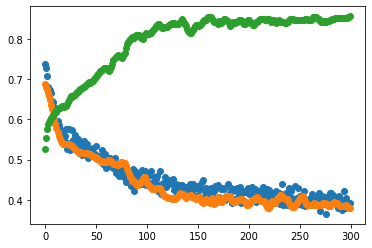

In [ ]:
train_losses, test_losses, acc_roc, best_acc  = train(100)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)
plt.scatter(range(len(acc_roc)), acc_roc)

In [ ]:
print('Лучшая точность:', np.round((best_acc*100), 2) , '%')

Лучшая точность: 85.6 %


## Обучение модели. Часть вторая.

Так как срок дедлайна сдвинули на неделю, больше не будем предсказывать товары заменители, а модель для их предсказания рассмотрем во второй главе. 

Для начаал создадим такую-же сеть но уже с новыми данными, точность должна повыситься т.к. класс товара заменителя должен быть сложным для предсказаний.

In [ ]:
# Загрузим модель до определения классов
stack_tables = pd.read_csv('/content/drive/My Drive/Lenta/backups/stack_tables_coded.csv')
stack_tables = stack_tables.set_index(stack_tables['material'])

In [ ]:
# Изменим функции классификации товаров:
%%time
#for food
for second in range(60):
    x = len(stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == second)]) # Проверка условий нахождения в иерархическом классе 2-го уровня.
    if x > 0:

      # Проверка условий нахождения в иерархическом классе 3-го уровня.
      for third in range(391):
        y = len(stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)])
        if y > 0:
          
          # Осортируем полученый список по количеству покупок.
          df = stack_tables[(stack_tables.hier_level_1 == 0) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)].sort_values('sales_count', ascending=False)[:10]
              
          for fourth in pd.unique(df.hier_level_4):

            # Если в данном иерархическом классе товаров больше 2х, то сравниваем колличество покупок и выделяем чрезвычайно важный и его заменитель.
            if len(df[df.hier_level_4 == fourth]) >= 2:              
              if (df[df.hier_level_4 == fourth].sales_count[0] / df[df.hier_level_4 == fourth].sales_count[1]) > threshold:

                df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)[:2]
      
                stack_tables.at[df2.index[0], 'category'] = 1  # Теперь присуждаем класс 1.
                #stack_tables.at[df2.index[1], 'category'] = 1  # Убираем строчку.

            # Если товар единственный в своем классе и его много берут, тоже считаем его чрезвычайно важным.
            elif len(df[df.hier_level_4 == fourth]) == 1:
               df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)
               if df2['sales_count'].item() > 150:
                stack_tables.at[df2.index[0], 'category'] = 1

CPU times: user 29.5 s, sys: 1.56 s, total: 31 s
Wall time: 31.3 s


In [ ]:
%%time
#for not food
for second in range(60):
    x = len(stack_tables[(stack_tables.hier_level_1 == 1) & (stack_tables.hier_level_2 == second)]) # Проверка условий нахождения в иерархическом классе 2-го уровня.
    if x > 0:

      # Проверка условий нахождения в иерархическом классе 3-го уровня.
      for third in range(391):
        y = len(stack_tables[(stack_tables.hier_level_1 == 1) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)])
        if y > 0:
          
          # Осортируем полученый список по количеству покупок.
          df = stack_tables[(stack_tables.hier_level_1 == 1) & (stack_tables.hier_level_2 == second) & (stack_tables.hier_level_3 == third)].sort_values('sales_count', ascending=False)[:10]
              
          for fourth in pd.unique(df.hier_level_4):

            # Если в данном иерархическом классе товаров больше 2х, то сравниваем колличество покупок и выделяем чрезвычайно важный и его заменитель.
            if len(df[df.hier_level_4 == fourth]) >= 2:              
              if (df[df.hier_level_4 == fourth].sales_count[0] / df[df.hier_level_4 == fourth].sales_count[1]) > threshold:

                df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)[:2]
      
                stack_tables.at[df2.index[0], 'category'] = 1  # Устанавливаем категорию чрезвычайно важного товара.
                #stack_tables.at[df2.index[1], 'category'] = 1  # И его заменителя.

            # Если товар единственный в своем классе и его много берут, тоже считаем его чрезвычайно важным.
            elif len(df[df.hier_level_4 == fourth]) == 1:
               df2 = df[df.hier_level_4 == fourth].sort_values('sales_count', ascending=False)
               if df2['sales_count'].item() > 150:
                stack_tables.at[df2.index[0], 'category'] = 1

CPU times: user 21.3 s, sys: 1.18 s, total: 22.5 s
Wall time: 22.7 s


In [ ]:
print(len(stack_tables[stack_tables.category == 1]), len(stack_tables[stack_tables.category == 0]))

511 85940


In [ ]:
# Удалим размножившееся стлбцы и вернем привычную индексацию
stack_tables.drop(['material'], axis='columns', inplace=True)
stack_tables.drop(['material.1'], axis='columns', inplace=True)
stack_tables.reset_index(level=0, inplace=True)
# Проверим
stack_tables.head()

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
0,35cbdf61de9e19c8b417327aaef14c88,1,56,250,1197,536,0,0,156.0,118.744936
1,f0fc5e654a81a7c4b8ba8d7c26546e14,1,56,250,1052,2412,0,0,28.0,99.974643
2,353693e64fb5f9e2d29746d7fe6edf1e,1,56,291,568,2564,0,0,36.0,3.479722
3,5d9e0b4302ce95448cae72165ff4cf5b,1,56,291,568,2564,0,0,21.0,3.481905
4,69374dfb9642c83bd073e1a913af6609,1,50,380,1438,154,0,0,25.0,167.461200


In [ ]:
# Backup
stack_tables.to_csv('/content/drive/My Drive/Lenta/backups/binar_table.csv')

In [ ]:
#Удалим рандомно строки с категорией товаров 0
learn_table = stack_tables.copy()
to_remove = np.random.choice(learn_table[learn_table['category']==0].index,size=(len(stack_tables)-2000),replace=False)
learn_table.drop(to_remove, inplace = True)

In [ ]:
features = learn_table[feature_columns]
target = learn_table[target_column]
# Применим one-hot-encoding
target = to_categorical(target)

# Нормализуем данные
features = (features - features.mean()) / features.std()

# Разделим данные на тест и валидационные
train_feat, valid_feat, train_labels, valid_labels = train_test_split(features, target, random_state=42)

# Превратим данные в тензоры, чтобы потом было удобнее
train_feat = torch.FloatTensor(train_feat.values)
train_labels = torch.FloatTensor(train_labels)
valid_feat = torch.FloatTensor(valid_feat.values)
valid_labels = torch.FloatTensor(valid_labels)

In [ ]:
torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    torch.nn.Linear(features.shape[1], 50),
    torch.nn.ReLU(), 
    torch.nn.Dropout(p=0.5), 
    torch.nn.BatchNorm1d(50), 
    torch.nn.Linear(50, 100), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.BatchNorm1d(100), 
    torch.nn.Linear(100,2)
)
    
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

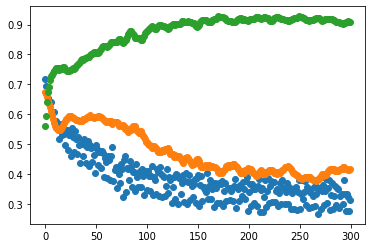

In [ ]:
train_losses, test_losses, acc_roc, best_acc  = train(100)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)
plt.scatter(range(len(acc_roc)), acc_roc)

In [ ]:
print('Лучшая точность:', np.round((best_acc*100), 2) , '%')

Лучшая точность: 92.78 %


Точность модели ожидаемо возросла. Теперь займемся решением задач оптимизации. Сначала определим лучшее соотношение классов для обучающей выборки, и попробуем скопировать классы чрезвычайно важных товаров попутно увеличивая колличество товаров 0-го класса. Для получения справедливой оценки точности, валидационную часть оставим в соотношении классов 50 на 50, что бы скор не сглаживался на фоне доминирования 0-го класса над первым.

In [ ]:
# Сразу сделае нормализацию данных
np.random.seed(42)
binary_data = pd.read_csv('/content/drive/My Drive/Lenta/backups/binar_table.csv')
binary_data[feature_columns] = (binary_data[feature_columns]- binary_data[feature_columns].mean()) / binary_data[feature_columns].std()

In [ ]:

from sklearn.utils import shuffle
# Заберем 30% данных от первого класса для валидации, в случайном порядке.
valid_cat1 = binary_data.copy()
valid_cat1 = valid_cat1[valid_cat1.category == 1]
valid_cat1 = shuffle(valid_cat1)
valid_cat1 = valid_cat1[:170] # 30% от категории 1

In [ ]:
# и равнозначное колличество товаров 0-й категории
valid_cat2 = binary_data.copy()
valid_cat2 = valid_cat2[valid_cat2.category == 0]
valid_cat2 = shuffle(valid_cat2)
valid_cat2 = valid_cat2[:200] 

In [ ]:
valid = pd.concat([valid_cat1, valid_cat2])

In [ ]:
valid = shuffle(valid)


In [ ]:
valid.to_csv('/content/drive/My Drive/Lenta/backups/valid.csv')

Удалим валидационную часть из основной выборки

In [ ]:
binary_data.drop(valid.index, inplace=True)

In [ ]:
binary_data.reset_index(level=0, inplace=True)
valid.reset_index(level=0, inplace=True)

In [ ]:
#Удалим рандомно строки с категорией товаров 0
#Сделаем так несколько раз
train1 = binary_data.copy()
to_remove = np.random.choice(train1[train1['category']==0].index,size=(len(binary_data)-20000),replace=False)
train1.drop(to_remove, inplace = True)

train2 = binary_data.copy()
to_remove = np.random.choice(train2[train2['category']==0].index,size=(len(binary_data)-20000),replace=False)
train2.drop(to_remove, inplace = True)

train3 = binary_data.copy()
to_remove = np.random.choice(train3[train3['category']==0].index,size=(len(binary_data)-20000),replace=False)
train3.drop(to_remove, inplace = True)

train4 = binary_data.copy()
to_remove = np.random.choice(train4[train4['category']==0].index,size=(len(binary_data)-20000),replace=False)
train4.drop(to_remove, inplace = True)

train5 = binary_data.copy()
to_remove = np.random.choice(train5[train5['category']==0].index,size=(len(binary_data)-20000),replace=False)
train5.drop(to_remove, inplace = True)

In [ ]:
train_data = pd.concat([train1, train2])
train_data = pd.concat([train_data, train3])
train_data = pd.concat([train_data, train4])
train_data = pd.concat([train_data, train5])

In [ ]:
train_data = train2

In [ ]:
# Backup
train_data.to_csv('/content/drive/My Drive/Lenta/backups/train.csv')

Были опробованы разные сочетания колличественного соотношение классов, и количество повторяющихся блоков. Лучший показатель который удалось достичь был получен с одним блоком данных и соотношением 1 к 40



In [42]:
# Load
valid = pd.read_csv('/content/drive/My Drive/Lenta/backups/valid.csv')
train_data = pd.read_csv('/content/drive/My Drive/Lenta/backups/train.csv')

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [45]:
# Определяем данные
train_feat = train_data[feature_columns]
train_labels = train_data[target_column]

valid_feat = valid[feature_columns]
valid_labels = valid[target_column]

# One-hot
train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)

# Превратим в торч тензоры
train_feat = torch.FloatTensor(train_feat.values).to(device)
train_labels = torch.FloatTensor(train_labels).to(device)

valid_feat = torch.FloatTensor(valid_feat.values).to(device)
valid_labels = torch.FloatTensor(valid_labels).to(device)

In [57]:
torch.manual_seed(42) 
#np.random.seed(42)
model = nn.Sequential(
    torch.nn.Linear(train_feat.shape[1], 100),
    torch.nn.ReLU(), 
    torch.nn.Dropout(p=0.5), 
    torch.nn.BatchNorm1d(100), 
    torch.nn.Linear(100, 100), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.BatchNorm1d(100), 
    torch.nn.Linear(100,2)
)
model = model.to(device) 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

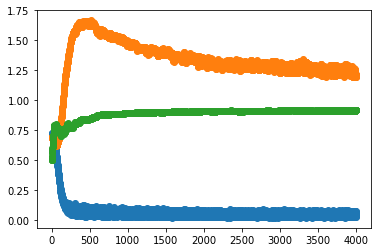

In [58]:
train_losses, test_losses, acc_roc, best_acc  = train(100)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)
plt.scatter(range(len(acc_roc)), acc_roc)

In [59]:
print('Лучшая точность:', np.round((best_acc*100), 2) , '%')

Лучшая точность: 91.93 %


Такая разница в значение лоссов объясняется тем что в тренировочной выборке соотношение классов 1к40 а в валидационной 1к1


Продолжим заниматься задачей оптимизации, определим оптимальные параметры модели - learning rate, количество нейронов в слое, количество эпох и глубину сети. Для определения эффективности увеличения слоев сети напишем цикл, который при каждой итерации будем увеличивать глубину модели.


Лучшая точность: 92.24 %
Колличество блоков: 2


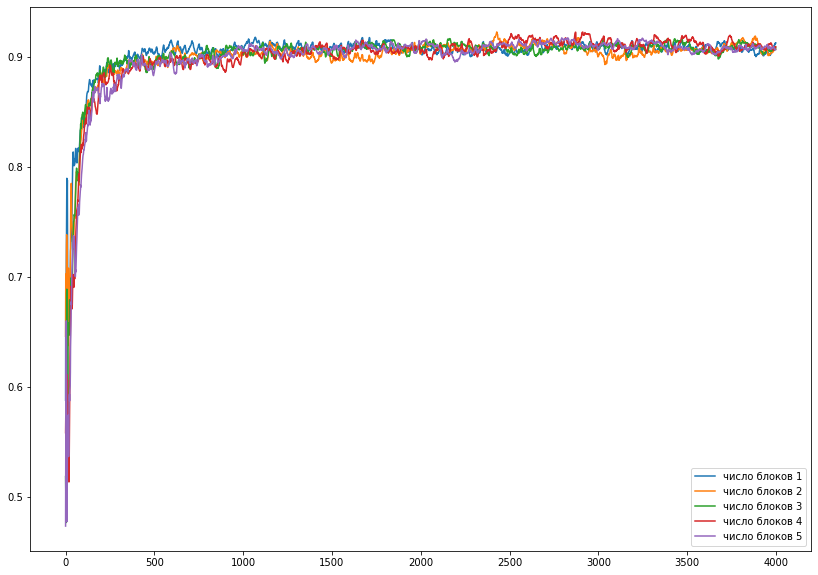

In [75]:
n_bloks, min_loss = range(1,6), []

fig, axs = plt.subplots(1, 1, figsize=(14,10))

acc_best = 0
best_block = 0

for n_blok in n_bloks:
    #print(n_blok)

    # перезадаем инициализаторы случаный чисел
    torch.manual_seed(42)   
    np.random.seed(42)

    # создаем модель
    header = nn.Sequential(
        nn.Linear(len(feature_columns), 150),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.BatchNorm1d(150))

    blocks = []
    for i in range(n_blok):
      blocks.append(nn.Linear(150, 150))
      blocks.append(nn.ReLU())
      blocks.append(nn.Dropout(p=0.5))
      blocks.append(nn.BatchNorm1d(150))

        

    blocks = nn.Sequential(*blocks)

    footer = nn.Sequential(
        nn.Linear(150, 2))

    model = nn.Sequential(header, blocks, footer)
    model = model.to(device)

    # задаем Loss функцию и оптимизатор
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) # все параметры модели

    train_losses, test_losses, acc_rocc, best_acc = train(100)

    # Запомним наилучшее значние точности
    if acc_rocc[np.argmax(acc_rocc)] > acc_best:
      acc_best = acc_rocc[np.argmax(acc_rocc)]
      best_block = n_blok

    #axs.plot(range(len(test_losses)), test_losses, label=f'число блоков {n_blok}')
    axs.plot(range(len(acc_rocc)), acc_rocc, label=f'число блоков {n_blok}')
    model.train(False)
    min_loss.append(np.min(test_losses))

plt.legend()

print('Лучшая точность:', np.round((acc_best*100), 2) , '%')
print('Колличество блоков:', best_block)

Сохраним лучшую модель

In [76]:
torch.manual_seed(42) 
model = nn.Sequential(
    torch.nn.Linear(train_feat.shape[1], 150),
    torch.nn.ReLU(), 
    torch.nn.Dropout(p=0.5), 
    torch.nn.BatchNorm1d(150), 
    torch.nn.Linear(150, 150), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.BatchNorm1d(150),
    torch.nn.Linear(150, 150), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.BatchNorm1d(150),
    torch.nn.Linear(150,2)
)
model = model.to(device) 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

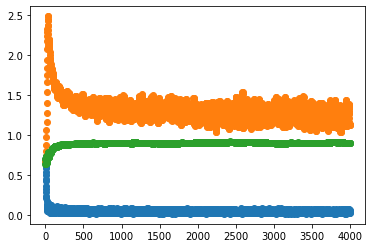

In [77]:
train_losses, test_losses, acc_roc, best_acc  = train(100,sv=True)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)
plt.scatter(range(len(acc_roc)), acc_roc)

In [78]:
print('Лучшая точность:', np.round((best_acc*100), 2) , '%')

Лучшая точность: 92.24 %


# Глава вторая.

Определение товара заменителя предложенное в первой главе имеет существенный недостаток - подразумевалось что такое товар обязательно принадлежит такой же иерархической категории как и товар чрезвычайной необходимости. Однако же товар заменитель скорее всего может иметь другую категорию (скорее всего т.к. доподлинно не известны иерархические категории). Попробую привести пример: студент зашел в магазин за сэндвичем с некоторым газированным напитком, в магазине такого напитка не оказалось (например кока-кола), и вместо того чтобы взять ближайший аналог(пепси), студент предпочел бутылку простой воды или сока. Данные товары будут иметь разные иерархические категории, но при этом бутылка воды оказалось наилучшим заменителем.

Чтобы учитывать такую поведенческую характеристику клиентов магазина, кажется хорошей идеей применить модель машинного обучения word2vec, где вместо корпуса текстов будут данные чеков, а именно категорий товаров.

**Подготовка данных**


Сперва необходимо преобразовать категории товаров в "слова", которые будут представлять словарь для модели

In [79]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from keras.utils import to_categorical
from collections import Counter
import random, math
import itertools

In [80]:
# Загрузим полученную в первой главе таблицу с артикулами товара и их кодированными категориями
mat = pd.read_csv('/content/drive/My Drive/Lenta/backups/stack_tables_coded.csv')

In [81]:
# В первой главе мы приняли, что только товары имеющие суммарные прадажи за год более 150 штук
# могут быть товарами категории 1 поэтому удалим артикулы товаров которые покупали менее 150 раз
mat = mat[mat['sales_count'] > 150]
mat.reset_index(level=0, inplace=True)


In [82]:
mat.head()

,index,material,material.1,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
0,0,35cbdf61de9e19c8b417327aaef14c88,35cbdf61de9e19c8b417327aaef14c88,1,56,250,1197,536,0,0,156.0,118.744936
1,14,c10f24786480fb3193733c6166d3a37d,c10f24786480fb3193733c6166d3a37d,1,59,163,749,557,0,0,228.0,94.906447
2,18,2ff67aaf79e5a7aa52d36fba95c41f9b,2ff67aaf79e5a7aa52d36fba95c41f9b,1,23,10,1940,2826,0,0,152.0,53.749868
3,28,92ec5f13056d1c2c7c8d2df6ee545909,92ec5f13056d1c2c7c8d2df6ee545909,0,28,66,704,3300,0,0,911.0,22.969737
4,30,255331bfbfe72c0a0bb5a2786ae52ed4,255331bfbfe72c0a0bb5a2786ae52ed4,0,28,267,1339,3300,0,0,408.0,13.765466


In [83]:
# Удалим из таблицы не интересующие нас столбцы
mat.drop(['material.1'],axis='columns', inplace=True)
mat.drop(['vendor'],axis='columns', inplace=True)
mat.drop(['is_alco'],axis='columns', inplace=True)
mat.drop(['category'],axis='columns', inplace=True)
mat.drop(['sales_count'],axis='columns', inplace=True)
mat.drop(['sales_sum'],axis='columns', inplace=True)
mat.drop(['index'],axis='columns', inplace=True)

In [84]:
# Переведем столбцы категорий в тип строки
mat['hier_level_1'] = mat['hier_level_1'].apply(str)
mat['hier_level_2'] = mat['hier_level_2'].apply(str)
mat['hier_level_3'] = mat['hier_level_3'].apply(str)
mat['hier_level_4'] = mat['hier_level_4'].apply(str)

In [85]:
# Сделаем кодировку категорий товаров в "словесную" форму
for i in range(len(mat['hier_level_4'])):
  if len(mat['hier_level_4'][i]) == 1:
    mat['hier_level_4'][i] = '000' + mat['hier_level_4'][i]
  if len(mat['hier_level_4'][i]) == 2:
    mat['hier_level_4'][i] = '00' + mat['hier_level_4'][i]
  if len(mat['hier_level_4'][i]) == 3:
    mat['hier_level_4'][i] = '0' + mat['hier_level_4'][i] 

for i in range(len(mat['hier_level_3'])):
  if len(mat['hier_level_3'][i]) == 2:
    mat['hier_level_3'][i] = '0' + mat['hier_level_3'][i]
  if len(mat['hier_level_3'][i]) == 1:
    mat['hier_level_3'][i] = '00' + mat['hier_level_3'][i] 

for i in range(len(mat['hier_level_2'])):
  if len(mat['hier_level_2'][i]) == 1:
    mat['hier_level_2'][i] = '0' + mat['hier_level_2'][i]

mat['code'] = 'a' + mat['hier_level_1'] + mat['hier_level_2'] + mat['hier_level_3'] + mat['hier_level_4'] + 'a'

In [86]:
mat.drop(['hier_level_1'],axis='columns', inplace=True)
mat.drop(['hier_level_2'],axis='columns', inplace=True)
mat.drop(['hier_level_3'],axis='columns', inplace=True)
mat.drop(['hier_level_4'],axis='columns', inplace=True)

In [87]:
mat

,material,code
0,35cbdf61de9e19c8b417327aaef14c88,a1562501197a
1,c10f24786480fb3193733c6166d3a37d,a1591630749a
2,2ff67aaf79e5a7aa52d36fba95c41f9b,a1230101940a
3,92ec5f13056d1c2c7c8d2df6ee545909,a0280660704a
4,255331bfbfe72c0a0bb5a2786ae52ed4,a0282671339a
...,...,...
17500,b2e546d1674313345ef8356dffc8f12f,a0223161395a
17501,368e30a7c8d2fd90fd31a0ca060f6716,a0552021596a
17502,312fd7354caf59bf460ef03533e8a3f7,a0572600223a
17503,9084fe2d523366f6304e1baa498d063d,a0103471470a


In [ ]:
mat.to_csv('/content/drive/My Drive/Lenta/backups/words_coded.csv')

In [ ]:
mat = pd.read_csv('/content/drive/My Drive/Lenta/backups/words_coded.csv',dtype=object, index_col=0)

Такая кодировка поможет нам легко взаимодействовать между обычными таблицами и эмбедингами

Теперь необходимо создать корпус покупок

In [88]:
trans = pd.read_csv('/content/drive/My Drive/Lenta/transactions.csv')

In [89]:
trans.head()

,Unnamed: 0,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo
0,0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,4,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0
1,1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,3,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.0,249.99,1
2,2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,12,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
3,3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,13,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
4,4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,11,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.0,53.98,1


In [ ]:
# Удалим не нужные нам столбцы из таблицы
trans.drop(['Unnamed: 0'],axis='columns', inplace=True)
trans.drop(['plant'],axis='columns', inplace=True)
trans.drop(['chq_date'],axis='columns', inplace=True)
trans.drop(['client_id'],axis='columns', inplace=True)
trans.drop(['sales_count'],axis='columns', inplace=True)
trans.drop(['sales_sum'],axis='columns', inplace=True)
trans.drop(['is_promo'],axis='columns', inplace=True)
trans.drop(['chq_position'],axis='columns', inplace=True)

In [ ]:
# Превратим таблицу mat в словарь
mat = mat.set_index('material')
mat = mat.to_dict()['code']

In [ ]:
# Добавим новый столбец к таблице покупок с кодировкой товаров
trans['mat'] = trans['material'].map(mat)
# Удалим пустые строки
trans = trans.dropna()
# И сгруппируем по чекам
trans = trans.groupby('chq_id').agg(lambda x: x.tolist())

In [ ]:
# Будем брать только чеки длиньше 2 и короче 15 покупок
trans = trans[trans['mat'].map(len) > 2]
trans = trans[trans['mat'].map(len) < 15]

In [ ]:
# Удалим не нужные колонки
trans.reset_index(level=0, inplace=True)
trans.drop(['chq_id'],axis='columns', inplace=True)
trans.drop(['material'],axis='columns', inplace=True)

In [ ]:
# Backup
trans.to_csv('/content/drive/My Drive/Lenta/corpus.csv')

In [ ]:
trans = pd.read_csv('/content/drive/My Drive/Lenta/corpus.csv')

In [ ]:
trans.head()

,Unnamed: 0,mat
0,0,"['a0261020881a', 'a0210150831a', 'a0370071626a..."
1,1,"['a0320830626a', 'a0282671339a', 'a0250221517a..."
2,2,"['a0273761149a', 'a0083270567a', 'a0371980047a..."
3,3,"['a1513720168a', 'a1513030675a', 'a0062070180a..."
4,4,"['a1522171650a', 'a0282671493a', 'a1311381491a..."
...,...,...
1712499,1712499,"['a0271081512a', 'a0351191815a', 'a1511641646a..."
1712500,1712500,"['a0322251577a', 'a0201830353a', 'a0201830476a..."
1712501,1712501,"['a1513030675a', 'a0461570596a', 'a0163431554a..."
1712502,1712502,"['a0322130711a', 'a0083330724a', 'a0083330724a..."


**Обработка данных для модели SkipGramm**

In [ ]:
# Переведем полученные данные в корпус состоящий из списка списков чеков
corpus = trans['mat'].values.tolist()

In [ ]:
corpus[:2]

[['a0261020881a',
  'a0210150831a',
  'a0370071626a',
  'a0352901860a',
  'a1513030675a',
  'a0370071626a'],
 ['a0320830626a',
  'a0282671339a',
  'a0250221517a',
  'a1513030675a',
  'a0460951323a',
  'a0271451289a']]

In [ ]:
# Создадим словарь
vocabulary = []
for sentence in corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [3]:
import pickle

In [ ]:
# Backup
with open('/content/drive/My Drive/Lenta/backups/w2i.pkl', 'wb') as f:
  pickle.dump(word2idx, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Backup
with open('/content/drive/My Drive/Lenta/backups/i2w.pkl', 'wb') as f:
  pickle.dump(idx2word, f, pickle.HIGHEST_PROTOCOL)

In [4]:
# Load
with open('/content/drive/My Drive/Lenta/backups/w2i.pkl', 'rb') as f:
  word2idx = pickle.load(f)

In [5]:
# Load
with open('/content/drive/My Drive/Lenta/backups/i2w.pkl', 'rb') as f:
  idx2word = pickle.load(f)

In [ ]:
vocabulary_size

1228

In [ ]:
# Переведем корпус в числа согласно словарю и обернем в тензор
np_corpus = []
for sentence in corpus:
  np_corpus.append(([word2idx[w] for w in sentence])) 

np_corpus = np.array([np.array(i) for i in np_corpus])

In [ ]:
# Backup
np.save('/content/drive/My Drive/Lenta/backups/corpus', np_corpus)

In [6]:
# Load
np_corpus = np.load('/content/drive/My Drive/Lenta/backups/corpus.npy', allow_pickle= True)

In [7]:
# Товары и как часто они встречались
word_counts = dict(Counter(list(itertools.chain.from_iterable(np_corpus))))

In [8]:
# Создадим массив для негативного контекста
negatives =[]
pow_frequency = np.array(list(word_counts.values())) ** 0.5
words_pow = sum(pow_frequency)
ratio = pow_frequency / words_pow
count = np.round(ratio * 1e8)
for wid, c in enumerate(count):
  negatives += [wid] * int(c)
negatives = np.array(negatives)
np.random.shuffle(negatives)

In [9]:
""" Теперь необходимо создать функцию трейна, в которой будет генерироваться батчи
в виде слово-контекст-негативный контекст и учить на этом нашу модель
"""
from tqdm import tqdm
length = len(np_corpus)

def train(skip_gram_model, iterations):
  losses=[]
  for iteration in range(iterations):

    print("\n\n\nIteration: " + str(iteration + 1))
    optimizer = torch.optim.SparseAdam(list(w2v_model.parameters()), lr=0.001)
    running_loss = 0.0

    for num_batches in tqdm(range((length // 2000)+1)):

      target = []
      context = []
      negative = []
      w = 4
      indx1 = num_batches*2000
      indx2 = indx1+2000

      # Формируем батч слово-контекст-негативный и переводим к торч тензорам
      if num_batches != (length // 2000):
        for text in np_corpus[indx1:indx2]:
          for i, word in enumerate(text):

            first_context_index = max(0,i-w)
            last_context_index = min(i+w, len(text))

            for j in range(first_context_index, last_context_index):
              if i!=j:
                target.append(word)
                context.append(text[j])
                negative.append(np.random.choice(negatives, 3))

      # Для последнего батча
      elif num_batches == (length // 2000):

        for text in np_corpus[1712000:]:
          for i, word in enumerate(text):

            first_context_index = max(0,i-w)
            last_context_index = min(i+w, len(text))

            for j in range(first_context_index, last_context_index):
              if i!=j:
                target.append(word)
                context.append(text[j])
                negative.append(np.random.choice(negatives, 4))
      
      target_tr = torch.LongTensor(target).to(device)
      context_tr = torch.LongTensor(context).to(device)
      negative_tr = torch.LongTensor(negative).to(device)
  
      # Делаем предсказания и шаг
      optimizer.zero_grad()
      loss = skip_gram_model.forward(target_tr, context_tr, negative_tr)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
  return losses


In [10]:
class SkipGramModel(nn.Module):

    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)

        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -torch.nn.functional.logsigmoid(score)

        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(torch.nn.functional.logsigmoid(-neg_score), dim=1)

        return torch.mean(score + neg_score)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Создаем модель, 1228 - размер словаря
w2v_model = SkipGramModel(1228,300)

In [14]:
w2v_model = w2v_model.to(device)

In [15]:
%%time
# Обучим
losses = train(w2v_model,10)

  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 1


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 2


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 3


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 4


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 5


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 6


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 7


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 8


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 9


  0%|          | 0/857 [00:00<?, ?it/s]




Iteration: 10


100%|██████████| 857/857 [20:33<00:00,  1.44s/it]

CPU times: user 3h 22min 7s, sys: 11min 11s, total: 3h 33min 19s
Wall time: 3h 23min 26s


In [18]:
# Backup
with open('/content/drive/My Drive/Lenta/backups/loss.pkl', 'wb') as f:
  pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)

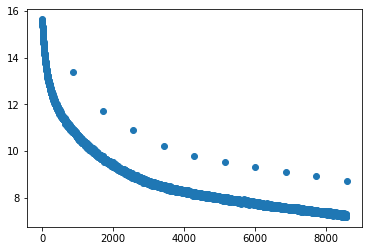

In [16]:
plt.scatter(range(len(losses)), losses)

In [17]:
torch.save(w2v_model.state_dict(), '/content/drive/My Drive/Lenta/models/w2v.pt')

Посмотрим на результаты

In [29]:
def most_similar(word, top_k=8):
        index = word2idx[word]
        index = torch.tensor(index, dtype=torch.long).unsqueeze(0)
        emb = w2v_model.u_embeddings(index)
        sim = torch.mm(emb, w2v_model.u_embeddings.weight.transpose(0, 1))
        nearest = (-sim[0]).sort()[1][1: top_k + 1]
        top_list = []
        for k in range(top_k):
            close_word = idx2word[nearest[k].item()]
            top_list.append(close_word)
        return top_list

In [31]:
w2v_model.cpu()

SkipGramModel(
  (u_embeddings): Embedding(1228, 300, sparse=True)
  (v_embeddings): Embedding(1228, 300, sparse=True)
)

In [32]:
most_similar('a0101291313a')

['a0082200204a',
 'a0083270931a',
 'a0102451325a',
 'a0471841858a',
 'a0160711125a',
 'a0063730976a',
 'a0371980764a',
 'a0250291128a']

# Глава третья.
У нас получились две модели, осталось собрать их в одно целое

In [12]:
import numpy as np
import pandas as pd
import torch
import pickle
from torch import nn
from sklearn.utils import shuffle

Создадим данные для теста

In [3]:
data_table = pd.read_csv('/content/drive/My Drive/Lenta/backups/final_table.csv')
data_table = shuffle(data_table)
data_table = shuffle(data_table)
data = data_table[data_table.category ==1][1:6]
data = pd.concat([data,data_table[data_table.category ==0][:5]])
# Backup
data.to_csv('/content/drive/My Drive/Lenta/backups/data_test.csv',index=False)

In [6]:
# Load
data = pd.read_csv('/content/drive/My Drive/Lenta/backups/data_test.csv')

In [7]:
data

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
0,aae82b282f6d372a6c90970b05cd9d11,0,35,17,104,3191,0,1,6423.000,82.803243
1,b6dec6e25b6b0556bac1dde55b6322e9,0,8,333,1273,407,0,1,5330.000,15.765158
2,d9b48f1f15e4a6a87b29ad0441b81332,0,10,129,1313,2640,0,1,2265.000,193.326998
3,7f77239687e6662acf818be678f17868,1,51,61,575,257,0,1,1402.000,13.187361
4,c33f232dcbbfaca29390e7ffb7c3602a,1,3,174,1294,2217,0,1,14.000,175.267143
5,1362d54095decbb0831f0e2b7309ee3d,0,10,129,1313,2866,0,0,3.919,253.886195
6,3408ff7ea34c72b2f21d1e20349b3112,0,10,241,822,3140,0,0,3.000,299.973333
7,aa015fa918dde2e11b1f8428b348053b,1,30,57,646,3063,0,0,40.000,348.239250
8,ee7633cde6b02678bf19ae34e106d109,1,34,389,1378,2851,0,0,11.000,749.361818
9,3ddfafc81cc845600fab3555488336ea,1,42,215,918,3792,0,0,25.000,58.446000


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# Подготовим данные для использованияв модели №1
feature_columns = ['hier_level_1', 'hier_level_2', 'hier_level_3', 'hier_level_4', 'vendor', 'is_alco', 'sales_count', 'sales_sum']
test_data = data[feature_columns]
if sum(test_data['is_alco']) == 0:
  test_data = (test_data - test_data.mean()) / test_data.std()
  test_data['is_alco'] = 0

elif sum(test_data['is_alco']) != 0:
  test_data = (test_data - test_data.mean()) / test_data.std()

test_data = torch.FloatTensor(test_data.values).to(device)

In [15]:
# Объявим модель
torch.manual_seed(42) 
model = nn.Sequential(
    torch.nn.Linear(test_data.shape[1], 150),
    torch.nn.ReLU(), 
    torch.nn.Dropout(p=0.5), 
    torch.nn.BatchNorm1d(150), 
    torch.nn.Linear(150, 150), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.BatchNorm1d(150),
    torch.nn.Linear(150, 150), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.BatchNorm1d(150),
    torch.nn.Linear(150,2)
)
binary_model = model.to(device) 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

In [16]:
# Загрузим веса
binary_model.load_state_dict(torch.load('/content/drive/My Drive/Lenta/models/binary_model.pt'))

<All keys matched successfully>

In [17]:
binary_model.eval()

Sequential(
  (0): Linear(in_features=8, out_features=150, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=150, out_features=150, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=150, out_features=150, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=150, out_features=2, bias=True)
)

In [ ]:
# Сделаем предсказания
x = torch.sigmoid(binary_model(test_data).detach())
out_data = data.copy()
for i, line in enumerate(x):
  if line[0] < 1:
    out_data['category'][i] = 1
  elif line[0] == 1:
    out_data['category'][i] = 0

In [19]:
# Модель обозначила 4 из 5х товаров.
out_data = out_data[out_data.category == 1]
out_data

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_alco,category,sales_count,sales_sum
0,aae82b282f6d372a6c90970b05cd9d11,0,35,17,104,3191,0,1,6423.0,82.803243
1,b6dec6e25b6b0556bac1dde55b6322e9,0,8,333,1273,407,0,1,5330.0,15.765158
2,d9b48f1f15e4a6a87b29ad0441b81332,0,10,129,1313,2640,0,1,2265.0,193.326998
3,7f77239687e6662acf818be678f17868,1,51,61,575,257,0,1,1402.0,13.187361


Подготовим данные дляиспользования во второй модели

In [20]:
# Переведем столбцы категорий в тип строки
out_data['hier_level_1'] = out_data['hier_level_1'].apply(str)
out_data['hier_level_2'] = out_data['hier_level_2'].apply(str)
out_data['hier_level_3'] = out_data['hier_level_3'].apply(str)
out_data['hier_level_4'] = out_data['hier_level_4'].apply(str)

In [ ]:
# Сделаем кодировку категорий товаров в "словесную" форму
for i in range(len(out_data['hier_level_4'])):
  if len(out_data['hier_level_4'][i]) == 1:
    out_data['hier_level_4'][i] = '000' + out_data['hier_level_4'][i]
  if len(out_data['hier_level_4'][i]) == 2:
    out_data['hier_level_4'][i] = '00' + out_data['hier_level_4'][i]
  if len(out_data['hier_level_4'][i]) == 3:
    out_data['hier_level_4'][i] = '0' + out_data['hier_level_4'][i] 

for i in range(len(out_data['hier_level_3'])):
  if len(out_data['hier_level_3'][i]) == 2:
    out_data['hier_level_3'][i] = '0' + out_data['hier_level_3'][i]
  if len(out_data['hier_level_3'][i]) == 1:
    out_data['hier_level_3'][i] = '00' + out_data['hier_level_3'][i] 

for i in range(len(out_data['hier_level_2'])):
  if len(out_data['hier_level_2'][i]) == 1:
    out_data['hier_level_2'][i] = '0' + out_data['hier_level_2'][i]

out_data['code'] = 'a' + out_data['hier_level_1'] + out_data['hier_level_2'] + out_data['hier_level_3'] + out_data['hier_level_4'] + 'a'

In [22]:
# Добавим и объявим модель w2v
class SkipGramModel(nn.Module):

    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)

        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -torch.nn.functional.logsigmoid(score)

        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(torch.nn.functional.logsigmoid(-neg_score), dim=1)

        return torch.mean(score + neg_score)

In [23]:
w2v = SkipGramModel(1228,300)
w2v.load_state_dict(torch.load('/content/drive/My Drive/Lenta/models/w2v.pt'))

<All keys matched successfully>

In [24]:
w2v = w2v.eval().cpu()

In [25]:
# Загрузим словари
import pickle
# Load
with open('/content/drive/My Drive/Lenta/backups/w2i.pkl', 'rb') as f:
  word2idx = pickle.load(f)

# Load
with open('/content/drive/My Drive/Lenta/backups/i2w.pkl', 'rb') as f:
  idx2word = pickle.load(f)

In [26]:
# функция для поиска соседей
def most_similar(word, top_k=8):
        index = word2idx[word]
        index = torch.tensor(index, dtype=torch.long).unsqueeze(0)
        emb = w2v.u_embeddings(index)
        sim = torch.mm(emb, w2v.u_embeddings.weight.transpose(0, 1))
        nearest = (-sim[0]).sort()[1][1: top_k + 1]
        top_list = []
        for k in range(top_k):
            close_word = idx2word[nearest[k].item()]
            top_list.append(close_word)
        return top_list

In [27]:
# загрузим ранее созданную табилцу, чтобы смотреть колличество покупок
mat = pd.read_csv('/content/drive/My Drive/Lenta/backups/stack_tables_coded.csv')

In [28]:
# Добавим столбцы к итоговой колонке
out_data['subling_1']= None
out_data['subling_2']= None
out_data['subling_3']= None

In [ ]:
# Запишем функцию которая будет добовлять товары заменители


for idx, line in enumerate(out_data['code']):
  #print(idx)
  similars = most_similar(line)
  z=0
  for i, simular in enumerate(similars):
    if int(simular[1:2]) == int(line[1:2]):
      if z == 0:
        df = mat[(mat.hier_level_1 == int(simular[1:2])) & (mat.hier_level_2 == int(simular[2:4])) & (mat.hier_level_3 == int(simular[4:7])) & (mat.hier_level_4 == int(simular[7:11]))].sort_values('sales_count', ascending=False)[:1]
        out_data['subling_1'][idx] = df['material'].item()
        z+=1
      elif z == 1:
        df = mat[(mat.hier_level_1 == int(simular[1:2])) & (mat.hier_level_2 == int(simular[2:4])) & (mat.hier_level_3 == int(simular[4:7])) & (mat.hier_level_4 == int(simular[7:11]))].sort_values('sales_count', ascending=False)[:1]
        out_data['subling_2'][idx] = df['material'].item()
        z+=1
      elif z == 2:
        df = mat[(mat.hier_level_1 == int(simular[1:2])) & (mat.hier_level_2 == int(simular[2:4])) & (mat.hier_level_3 == int(simular[4:7])) & (mat.hier_level_4 == int(simular[7:11]))].sort_values('sales_count', ascending=False)[:1]
        out_data['subling_3'][idx] = df['material'].item()
        z+=1


In [ ]:
out_data.drop(['hier_level_1'],axis='columns', inplace=True)
out_data.drop(['hier_level_2'],axis='columns', inplace=True)
out_data.drop(['hier_level_3'],axis='columns', inplace=True)
out_data.drop(['hier_level_4'],axis='columns', inplace=True)
out_data.drop(['vendor'],axis='columns', inplace=True)

In [32]:
out_data.drop(['is_alco'],axis='columns', inplace=True)
out_data.drop(['category'],axis='columns', inplace=True)
out_data.drop(['sales_count'],axis='columns', inplace=True)
out_data.drop(['sales_sum'],axis='columns', inplace=True)
out_data.drop(['code'],axis='columns', inplace=True)

In [33]:
out_data

,material,subling_1,subling_2,subling_3
0,aae82b282f6d372a6c90970b05cd9d11,42898c9899c2753952a3d8b09d63fd0e,fcb725202de318d2cba0ae50ee3cc527,12dc217d78c3d79ef18c72d9e5f44436
1,b6dec6e25b6b0556bac1dde55b6322e9,1aa5e8f2ebc1a7a3e4ad35f636db5b79,cf77c564d5e25ba399bd232c90f38729,7897953d7cfcf423ae79b988e900211a
2,d9b48f1f15e4a6a87b29ad0441b81332,da0b812d15a9ffe6ff5fea1ae6053ac6,08947cc2c6c70caf3479b6ce8d9ad63c,df9cb53c7750e70ce75543fbd9dc31d4
3,7f77239687e6662acf818be678f17868,5141f9cf751c070f710b38ff9faa890e,ad74a0c50caa4132e82a9d3f226265ae,4d5be2d460be237368863cffd70bf148


In [34]:
out_data.to_csv('/content/drive/My Drive/Lenta/backups/out_data.csv',index=False)

# Выводы по работе


1.   По первой главе:


*   При подготовки данных для первой модели, данные сортировались по классам и не обращалось во внимание количество проданных товаров в классе к среднему количеству проданных товаров. Из-за этого 1 классом иногда маркируются товары, которые покупались совсем редко, что не логично. Так-же моделе сложно предсказывать такой товар( пример во главе 3, товар, имеющий маркер 1 категории и всего 14 продаж)
*   Модель была обучена на годовом обороте товаров, из-за этого не учитывает сезонность товаров.



2.   По второй главе:


*   Применение модели word2vec для структуризации потребительского поведения действительно кажется хорошей идеей, как развитие направления, можно использовать данные о возрасте и пола покупателей при составлении различных эмбедингов
*   Несмотря на, то что оценивать точность модели эмбедингов достаточно сложно + все данные захешированы. Полученная модель во второй главе, несмотря на небольшой лосс требует существенной доработки, к сожалению не успел заняться ее оптимизацией из-за большого времени обучения. Ради интереса воспользовался готовым API и обучил модель Gensim word2vec на этих же данных, ближайшие товары к искомому у такой модели в большинстве случаев имеют одинаковые первые три иерархических класса, что кажется более правильном при оценке качества таких моделей.



---

**Возможное развитие**


Изначально планировал создать еще третью модель, которая бы предсказывала продажи товаров в следующем месяце, но к сожалению, не хватило времени. Работа 3 моделей в тандеме: предсказание продаж - поиск чрезвычайно важных товаров в предсказанных продажах - поиск товаров заменителей, видится неплохой реализацией для коммерции.



